In [1]:
!which python
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak/experiments


In [14]:
%load_ext autoreload
%autoreload 2

import os
import datetime
from collections import defaultdict
import random

import torch
import torch.nn as nn 
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

import torchvision
from torchvision.transforms import v2
import torchvision.models as pt_models


import numpy as np
import sklearn
import scipy 
import matplotlib.pyplot as plt

import sps
import sls
from alig.th import AliG
from pt_methods import *
import models

import utils
from solve_binary_libsvm import solve_binary_libsvm
from base_module import BaseTrainingModule

import lightning as L
import torchmetrics
from lightning.pytorch import seed_everything, loggers

torch.set_default_dtype(torch.float64)

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [16]:
class MNISTDataModule(L.LightningDataModule):

    def __init__(self, data_dir: str = os.getenv("TORCHVISION_DATASETS_DIR"), batch_size: int = 32):
        super().__init__()

        self.data_dir = data_dir
        self.batch_size: int = batch_size
        self.num_labels: int = 10

        self.transform_train = v2.Compose([
            v2.RandomRotation(10),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            v2.ToImage(),
            v2.ToDtype(torch.get_default_dtype(), scale=True),
            v2.Normalize(
                (0.1307,), (0.3081,),
            ),
        ])

        self.transform_val = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.get_default_dtype(), scale=True),
            v2.Normalize(
                (0.1307,), (0.3081,),
            ),
        ])

    def setup(self, stage: str):

        if stage  == 'fit':
            self.train_dataset = torchvision.datasets.MNIST(self.data_dir, train=True, download=True, transform=self.transform_train)
            self.val_dataset = torchvision.datasets.MNIST(self.data_dir, train=False, download=True, transform=self.transform_val)
        if stage == 'test':
            self.val_dataset = torchvision.datasets.MNIST(self.data_dir, train=False, download=True, transform=self.transform_val)
        if stage == 'predict':
            self.val_dataset = torchvision.datasets.MNIST(self.data_dir, train=False, download=True, transform=self.transform_val)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=2, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=2, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=2, shuffle=False)


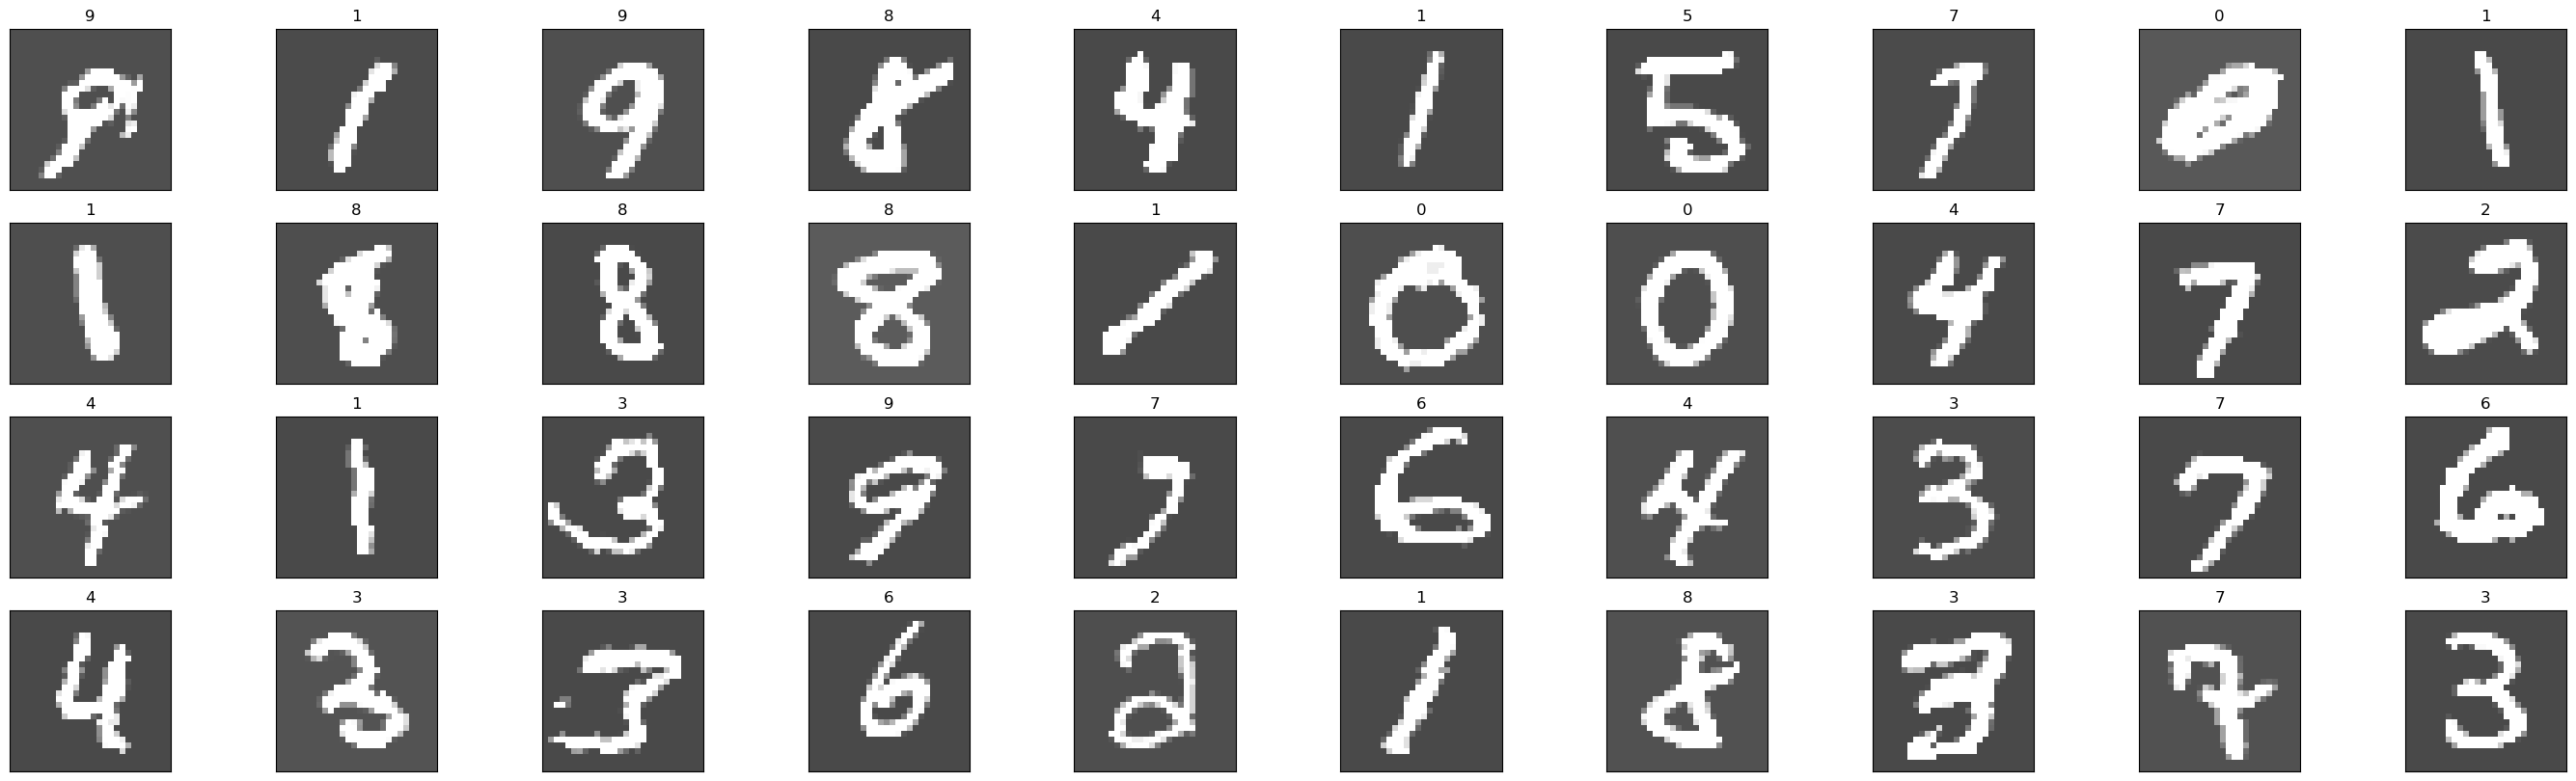

In [17]:
def im_convert(tensor):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

data_module = MNISTDataModule()
data_module.setup('fit')

fig = plt.figure(figsize=(35, 10)) 
d = data_module.train_dataset
for idx, sample in enumerate(RandomSampler(d, num_samples=40)):
    ax = fig.add_subplot(4, 10, idx+1, xticks=[], yticks=[]) 
    plt.imshow(im_convert(d[sample][0])) 
    # ax.set_title(data_module.labels[d[sample][1]])
    ax.set_title(d[sample][1])

In [18]:
torch.manual_seed(0)
model = models.LeNet5(num_classes=10).to(device)

w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print(f"Total parameters: {d:,}")  

Total parameters: 44,426


In [27]:
class MNISTClassifier(BaseTrainingModule):

    def __init__(self, num_labels: int, config: dict):

        self.num_labels = num_labels

        self.save_hyperparameters(
            {
                'dataset': 'MNIST',
                'task': 'multi-class-classification',
                'model': 'LeNet5',
                'config': config,
            }
        )

        super().__init__(config)

    def build_model(self):
        return models.LeNet5(num_classes=self.num_labels).to(device)

    def define_loss_fn(self):
        return nn.CrossEntropyLoss()

    def define_val_acc_metric(self):
        return torchmetrics.classification.MulticlassAccuracy(num_classes=self.num_labels)

    def unpack_batch(self, batch):
        x, y = batch
        return x.to(device), y.to(device)

In [ ]:
for seed in [0, 1, 2, 3, 4]:

    config = {
        'seed': seed,
        'max_epochs': 50,
        'batch_size': 256,
        'reg': 0.0,
        'optimizer': 'Adam',
        'optimizer_hparams': {
            'lr': 0.01,
        },
    }


    data_module = MNISTDataModule(batch_size=config['batch_size'])
    data_module.setup('fit')

    seed_everything(config['seed'], workers=True)

    model = MNISTClassifier(num_labels=data_module.num_labels, config=config)

    csv_logger = loggers.CSVLogger(
        save_dir=f"logs/{model.hparams['dataset']}",
        version=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        )

    import wandb
    from lightning.pytorch.loggers import WandbLogger

    wandb_logger = WandbLogger(project="TwinPolyak")

    wandb_logger.experiment.config.update(
        {
            'dataset/name': model.hparams['dataset'],
            'model': model.hparams['model'],
            'config': config,
        }
    )

    trainer = L.Trainer(
        max_epochs=config['max_epochs'], 
        logger=[csv_logger, wandb_logger], 
        accelerator='gpu',
        devices=1,
        log_every_n_steps=len(data_module.train_dataloader())
        )

    trainer.fit(model=model, datamodule=data_module)

    wandb.finish()

Seed set to 0


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | LeNet5             | 44.4 K | train
1 | loss_fn | CrossEntropyLoss   | 0      | train
2 | val_acc | MulticlassAccuracy | 0      | train
-------------------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▂▂▁▂▂▂▂▁▁▁▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇█████
val_acc,▁▅▆▇▇▅▇▇▇▆▆▆▇▆▇▆█▆▇▆▇▆▇▇▆▇▆██▇▇▇▇▇▇█▇█▇▇
val_loss,█▃▃▂▁▆▂▂▄▃▄▃▇▂▄▂▅▄▄▄▄▅▅▆▄▄▅▃▃▃▃▄▅▆▅▂▆▂▄▅
epoch,49
lr,0.01
train_loss,0.03841
trainer/global_step,11749
val_acc,0.98792


Seed set to 1


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | LeNet5             | 44.4 K | train
1 | loss_fn | CrossEntropyLoss   | 0      | train
2 | val_acc | MulticlassAccuracy | 0      | train
-------------------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇████
val_acc,▃▁▄▇▆▇▅▅▆▆▆▇▅▆▆▆▆▇█▆▇▇▆▆▆▅▆▇▆▆▇▆▆▇▅▅▇▆▆▇
val_loss,▃▆▄▁▃▁▃▃▃▃▃▃▄▃▄▃▄▄▂▃▃▄▄▄▄▅▅▅▅▄▄▆▄▄█▅▄▄▅▄
epoch,49
lr,0.01
train_loss,0.04097
trainer/global_step,11749
val_acc,0.98826


Seed set to 2


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | LeNet5             | 44.4 K | train
1 | loss_fn | CrossEntropyLoss   | 0      | train
2 | val_acc | MulticlassAccuracy | 0      | train
-------------------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [281]:
TORCHVISION_DATASETS_DIR = os.getenv("TORCHVISION_DATASETS_DIR")


transforms = v2.Compose([
        # v2.RandomRotation(10),
        # v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(
            (0.1307,), (0.3081,),
        ),
    ])

train_batch_size = 2048
test_batch_size = 2048

train_data = torchvision.datasets.MNIST(TORCHVISION_DATASETS_DIR, train=True, download=True, transform=transforms)
test_data = torchvision.datasets.MNIST(TORCHVISION_DATASETS_DIR, train=False, download=True, transform=transforms)

train_data = flip_labels_to_complements(train_data, corruption_prob=0.5)

train_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

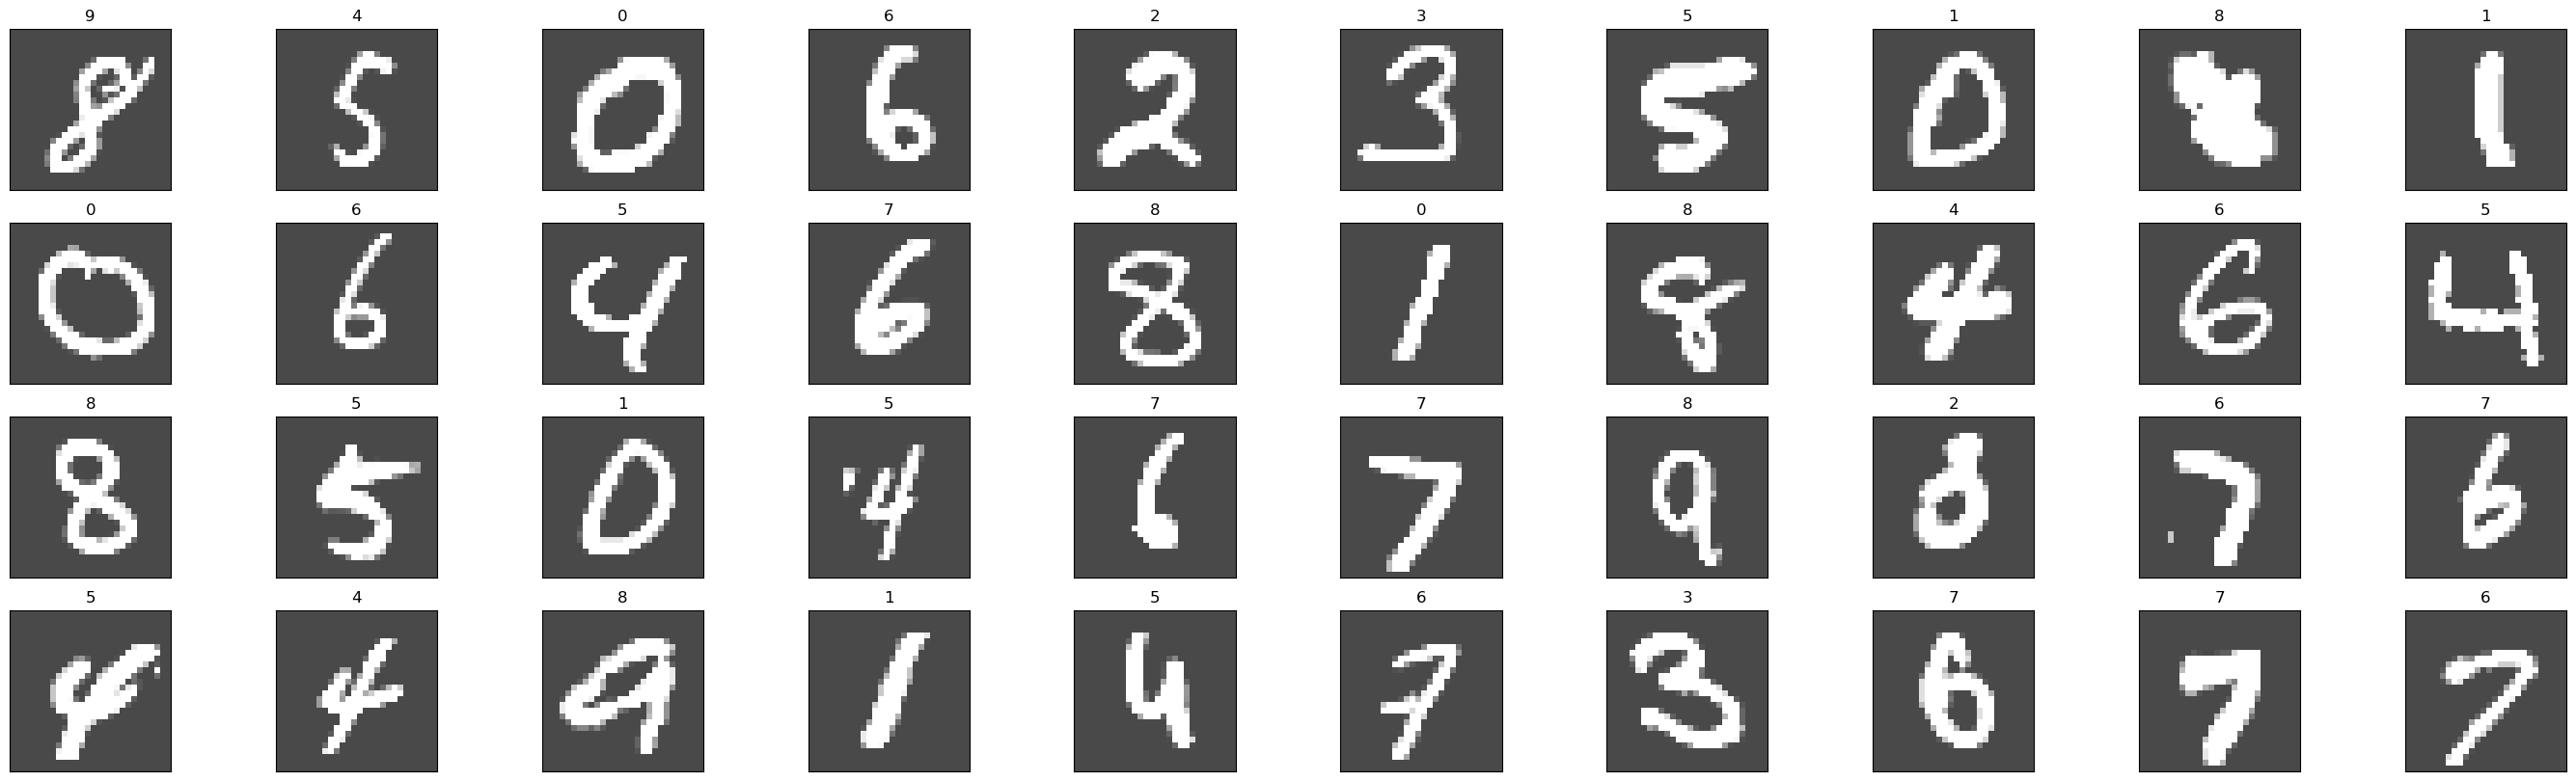

In [282]:
def im_convert(tensor):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

fig = plt.figure(figsize=(35, 10)) 
d = train_data
for idx, sample in enumerate(RandomSampler(d, num_samples=40)):
    ax = fig.add_subplot(4, 10, idx+1, xticks=[], yticks=[]) 
    plt.imshow(im_convert(d[sample][0])) 
    ax.set_title(d[sample][1])

In [47]:
torch.manual_seed(0)

TORCHVISION_DATASETS_DIR = os.getenv("TORCHVISION_DATASETS_DIR")

train_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(32, 32), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(10),
    v2.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.ToImage(),
    v2.ToDtype(torch.get_default_dtype(), scale=True),
    v2.Normalize(
        (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261),
    ),
])

test_transforms = v2.Compose([
    v2.Resize(size=(32, 32)),
    v2.CenterCrop((32, 32)),
    v2.ToImage(),
    v2.ToDtype(torch.get_default_dtype(), scale=True),
    v2.Normalize(
        (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261),
    ),
])

train_data = torchvision.datasets.CIFAR10(
    TORCHVISION_DATASETS_DIR, train=True, download=True, transform=train_transforms
    )
test_data = torchvision.datasets.CIFAR10(
    TORCHVISION_DATASETS_DIR, train=False, download=True, transform=test_transforms
    )

train_batch_size = 512
test_batch_size = 2048

train_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, num_workers=2)


In [283]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        return y
    
    
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 32)
        self.relu3 = nn.ReLU()
        # self.fc2 = nn.Linear(120, 84)
        # self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        # y = self.fc2(y)
        # y = self.relu4(y)
        y = self.fc3(y)
        return y

In [284]:
torch.manual_seed(0)
model = SimpleCNN(num_classes=10).to(device)

w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print(f"Total parameters: {d:,}")  

Total parameters: 11,126


In [287]:
torch.manual_seed(0)
model = models.WideResNet(num_classes=10, depth=16, widen_factor=8).to(device)
# model = LeNet5().to(device)

w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print(f"Total parameters: {d:,}")  

Total parameters: 10,961,370


In [166]:
class WideResNet16_8(models.WideResNet):
    def __init__(self, num_classes: int = 10):
        super(models.WideResNet, self).__init__(depth=16, num_classes=num_classes, widen_factor=8)

In [169]:
for x, y in train_dataloader:
    print(x.shape)
    output = model(x.to(device))
    print(output.shape)
    break

torch.Size([256, 1, 28, 28])
torch.Size([256, 10])


In [7]:
def mean_max_min(l):
    max_length = max(len(sublist) for sublist in l)
    
    mean_line = []
    max_line = []
    min_line = []
    for i in range(max_length):
        values_at_position = [sublist[i] for sublist in l if i < len(sublist)]
        mean_line.append(np.mean(values_at_position))
        max_line.append(np.max(values_at_position))
        min_line.append(np.min(values_at_position))

    return mean_line, max_line, min_line


def plotter(histories: dict,
                  colors=list(plt.cm.colors.XKCD_COLORS.keys()) + list(plt.cm.colors.BASE_COLORS), 
                  linestyles=["-" for _ in range(20)], 
                  linewidths=[1.5 for _ in range(20)], 
                  markers=[" " for _ in range(20)], 
                  markeredgecolor="dimgrey", 
                  markersize=8, 
                  alphas=[1.0 for _ in range(20)], 
                  f_star=None, suptitle=None, 
                  metrics=["train/loss", "train/grad_norm_sq", "train/acc", "lr"], y_scales=["log", "log", "linear", "log"],
                  mov_ave=[False for _ in range(20)],
                  x_labels=None, y_labels=None, x_labels_fs=16, y_labels_fs=16,
                  acc_ylim=None,
                  threshold=1e-10, xlims=None, tight_layout=True, legend_below=False,
                  filename=None):
    
    fig, ax = plt.subplots(1, len(metrics), figsize=(len(metrics) * 4, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
    
    for (label, history), c, ls, lw, m, alpha in zip(histories.items(), colors, linestyles, linewidths, markers, alphas):
        
        steps_per_epoch = len(history[0]["lr"]) / len(history[0]["train/loss"])
        
        for (ax_idx, metric), apply_ma in zip(enumerate(metrics), mov_ave):
            
            if metric in ["train/loss", "test/loss"]:
                if apply_ma:
                    res = [utils.moving_average(x[metric] - f_star, len(x[metric]) // 10) for x in history]
                else:
                    res = [x[metric] - f_star for x in history]
            else:
                if apply_ma:
                    res = [utils.moving_average(x[metric], len(x[metric]) // 10) for x in history]
                else:
                    res = [x[metric] for x in history]
            
            mean_line, max_line, min_line = mean_max_min(res)
            if metric == "lr":
                x = np.linspace(0, len(mean_line)/steps_per_epoch - 1, len(mean_line))
            else:
                x = np.linspace(0, len(mean_line) - 1, len(mean_line))
            
            markevery = [0,] + [x + np.random.randint(0, 10) for x in range(len(mean_line) // 5, len(mean_line) - 10, len(mean_line) // 5)]
                
            
            lbl = None
            if ax_idx == len(metrics) - 1:
                lbl = label
                
            ax[ax_idx].fill_between(x, max_line, min_line, color=c, alpha=0.2)
            ax[ax_idx].plot(x, mean_line, label=lbl, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
            ax[ax_idx].set_yscale(y_scales[ax_idx])
            
            if metric == "test/acc" and acc_ylim:
                ax[ax_idx].set_ylim(bottom=acc_ylim)

    for i, xlabel, ylabel, _ in zip(range(4), x_labels, y_labels, metrics):
        ax[i].set_xlabel(xlabel, fontsize=x_labels_fs)
        ax[i].set_ylabel(ylabel, fontsize=y_labels_fs)
        ax[i].grid()
    
    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])
    
    if legend_below:
        # Put a legend below current axis
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02), fancybox=True, shadow=True, ncol=len(histories))
    else:
        fig.legend()
    
    
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()

In [8]:
def compute_topk_accuracy(output, target, k=5):
    """Compute top-k accuracy for the given outputs and targets."""
    with torch.no_grad():
        # Get the top-k indices
        _, topk_indices = output.topk(k, dim=1)
        # Check if targets are in the top-k predictions
        correct = topk_indices.eq(target.view(-1, 1).expand_as(topk_indices))
        # Compute accuracy
        return correct.any(dim=1).float().mean().item()


def eval_model(model: nn.Module, criterion: nn.Module, dataloader: DataLoader): 
    test_epoch_loss = 0.0
    total = 0
    correct = 0
    top3_acc = 0.0
    top5_acc = 0.0
    for i, (batch_data, batch_target) in enumerate(dataloader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)
        
        outputs = model(batch_data)
        loss = criterion(outputs, batch_target)
        test_epoch_loss += loss.item() * batch_data.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total += batch_target.size(0)
        batch_correct = (predicted == batch_target).sum().item()
        batch_accuracy = batch_correct / batch_target.size(0)
        correct += batch_correct
        
        top3_acc += compute_topk_accuracy(outputs, batch_target, k=3) * batch_target.size(0)
        top5_acc += compute_topk_accuracy(outputs, batch_target, k=5) * batch_target.size(0)
        
    loss = test_epoch_loss / len(dataloader.sampler)
    top1_accuracy = correct / total
    top3_accuracy = top3_acc / total
    top5_accuracy = top5_acc / total

    return loss, (top1_accuracy, top3_accuracy, top5_accuracy)


def train_optimizer(
    optimizer,
    epochs: int, 
    seed: int = 0,
    **optimizer_kwargs) -> dict:
    
    torch.manual_seed(seed)
    
    num_classes = len(np.unique(train_dataloader.dataset.classes))
    model = SimpleCNN(num_classes=num_classes).to(device)
    optimizer = optimizer(model.parameters(), **optimizer_kwargs)
    criterion = nn.CrossEntropyLoss()

    history = defaultdict(list)

    for epoch in range(epochs):
        
        model.eval()
        with torch.inference_mode():
            loss, accuracy = eval_model(model, criterion, test_dataloader)
            history["test/loss"].append(loss)
            history["test/accuracy/top1"].append(accuracy[0])
            history["test/accuracy/top3"].append(accuracy[1])
            history["test/accuracy/top5"].append(accuracy[2])
            print(f"Epoch: {epoch} | Test loss: {loss} | Test accuracy: {accuracy[0]}")
        
        train_loss = 0.0
        model.train()
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)
            
            def closure():
                optimizer.zero_grad()
                outputs = model(batch_data)
                loss = criterion(outputs, batch_target)
                loss.backward()
                return loss

            if isinstance(optimizer, sps.Sps):
                loss = optimizer.step(closure=closure)
                history["lr"].append(optimizer.state["step_size"])
                train_loss += loss * batch_data.size(0)
            elif isinstance(optimizer, sls.Sls):
                def closure():
                    optimizer.zero_grad()
                    outputs = model(batch_data)
                    loss = criterion(outputs, batch_target)
                    return loss
                loss = optimizer.step(closure=closure)
                history["lr"].append(optimizer.state["step_size"])
                train_loss += loss.item() * batch_data.size(0)
            elif isinstance(optimizer, DecSPS):
                loss = optimizer.step(closure=closure)
                history["lr"].append(optimizer.step_size)
                train_loss += loss.item() * batch_data.size(0)
            elif isinstance(optimizer, Momo):
                loss = optimizer.step(closure=closure)
                history["lr"].append(optimizer.state["step_size_list"][-1])
                train_loss += loss.item() * batch_data.size(0)
            else:
                loss = optimizer.step(closure=closure)
                history["lr"].append(optimizer.param_groups[0]["lr"])
                train_loss += loss.item() * batch_data.size(0)
            
        history["train/loss"].append(train_loss / len(train_dataloader.sampler))
            
    return history


In [12]:
hist = train_optimizer(
    optimizer=torch.optim.SGD,
    epochs=10,
    lr=0.1,
    momentum=0.9,
)

Epoch: 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066
Epoch: 1 | Test loss: 2.1808261077880857 | Test accuracy: 0.1873
Epoch: 2 | Test loss: 0.8764545399665833 | Test accuracy: 0.7483
Epoch: 3 | Test loss: 0.349676509475708 | Test accuracy: 0.8953
Epoch: 4 | Test loss: 0.227505810713768 | Test accuracy: 0.9287
Epoch: 5 | Test loss: 0.14776198568344115 | Test accuracy: 0.9555
Epoch: 6 | Test loss: 0.1243447832584381 | Test accuracy: 0.9614
Epoch: 7 | Test loss: 0.10211241779327393 | Test accuracy: 0.9693
Epoch: 8 | Test loss: 0.09003230100274086 | Test accuracy: 0.9718
Epoch: 9 | Test loss: 0.0791203376352787 | Test accuracy: 0.9746


In [12]:
def train_twin_polyak_ma(epochs: int,
                      seed: int = 0,
                      **optimizer_kwargs) -> dict:
    
    torch.manual_seed(0)
    
    num_classes = len(np.unique(train_dataloader.dataset.classes))
    model_x = SimpleCNN(num_classes=num_classes).to(device)
    model_y = SimpleCNN(num_classes=num_classes).to(device)

    optimizer_x = TwinPolyakMA(model_x.parameters(), **optimizer_kwargs)
    optimizer_y = TwinPolyakMA(model_y.parameters(), **optimizer_kwargs)
    
    criterion = nn.CrossEntropyLoss()

    history = defaultdict(list)
    
    torch.manual_seed(seed)
    
    for epoch in range(epochs):
        
        model_x.eval()
        model_y.eval()
        with torch.inference_mode():
            loss_x, accuracy_x = eval_model(model_x, criterion, test_dataloader)
            loss_y, accuracy_y = eval_model(model_y, criterion, test_dataloader)
            
            if loss_x < loss_y:
                history["test/loss"].append(loss_x)
                history["test/accuracy/top1"].append(accuracy_x[0])
                history["test/accuracy/top3"].append(accuracy_x[1])
                history["test/accuracy/top5"].append(accuracy_x[2])
            else:
                history["test/loss"].append(loss_y)
                history["test/accuracy/top1"].append(accuracy_y[0])
                history["test/accuracy/top3"].append(accuracy_y[1])
                history["test/accuracy/top5"].append(accuracy_y[2])
                
            print(f"Epoch {epoch} | Test loss: {history["test/loss"][-1]} | Test accuracy: {history["test/accuracy/top1"][-1]}")
                
        train_loss = 0.0
        model_x.train()
        model_y.train()
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            outputs_x = model_x(batch_data)
            outputs_y = model_y(batch_data)
            
            loss_x = criterion(outputs_x, batch_target)
            loss_y = criterion(outputs_y, batch_target)


            optimizer_x.zero_grad()
            optimizer_y.zero_grad()

            # Important note: loss.backward() is called in momentim_step
            # so we do not need to call it again 
            h_x = optimizer_x.momentum_step(loss_x)
            h_y = optimizer_y.momentum_step(loss_y)

            if h_x > h_y:
                # optimizer_x.zero_grad()
                # loss_x.backward()
                loss_diff = (h_x - h_y)
                optimizer_x.step(loss_diff=loss_diff.item())
                history["lr"].append(optimizer_x.step_size.item())
                train_loss += loss_y.item() * batch_data.size(0)
            else:
                # optimizer_y.zero_grad()
                # loss_y.backward()
                loss_diff = (h_y - h_x)
                optimizer_y.step(loss_diff=loss_diff.item())
                history["lr"].append(optimizer_y.step_size.item())
                train_loss += loss_x.item() * batch_data.size(0)
        
        train_loss = train_loss / len(train_dataloader.sampler)
        history["train/loss"].append(train_loss)

    return history

[autoreload of pt_methods failed: Traceback (most recent call last):
  File "/home/farshed.abdukhakimov/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/farshed.abdukhakimov/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/farshed.abdukhakimov/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/farshed.abdukhakimov/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/farshed.abdukhakimov/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "

In [248]:
hist_stp = train_twin_polyak_ma(
    epochs=10,
    beta=0.9,
)

Epoch 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066
Epoch 1 | Test loss: 2.0533524337768556 | Test accuracy: 0.6092
Epoch 2 | Test loss: 1.200668952178955 | Test accuracy: 0.7576
Epoch 3 | Test loss: 0.5783502173900604 | Test accuracy: 0.8315
Epoch 4 | Test loss: 0.4379471028327942 | Test accuracy: 0.8737
Epoch 5 | Test loss: 0.41474713730812074 | Test accuracy: 0.8806
Epoch 6 | Test loss: 0.40416429018974304 | Test accuracy: 0.8841
Epoch 7 | Test loss: 0.3912863657951355 | Test accuracy: 0.888
Epoch 8 | Test loss: 0.3726345545768738 | Test accuracy: 0.8935
Epoch 9 | Test loss: 0.3860368266582489 | Test accuracy: 0.8846


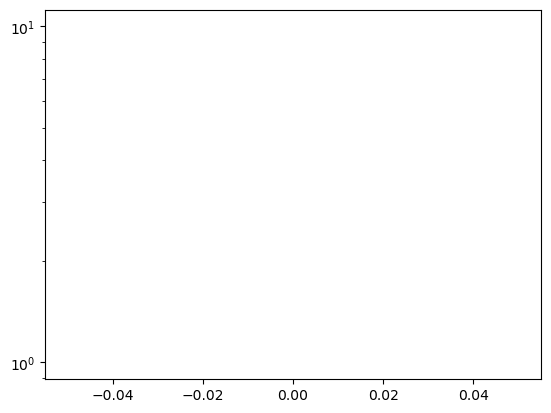

In [190]:
plt.semilogy(hist_stp["train/loss"])

In [242]:
def train_twin_polyak(epochs: int,
                      seed: int = 0,
                      **optimizer_kwargs) -> dict:
    
    torch.manual_seed(0)
    
    num_classes = len(np.unique(train_dataloader.dataset.classes))
    model_x = SimpleCNN(num_classes=num_classes).to(device)
    model_y = SimpleCNN(num_classes=num_classes).to(device)

    optimizer_x = TwinPolyak(model_x.parameters(), **optimizer_kwargs)
    optimizer_y = TwinPolyak(model_y.parameters(), **optimizer_kwargs)
    
    criterion = nn.CrossEntropyLoss()

    history = defaultdict(list)
    
    torch.manual_seed(seed)
    
    for epoch in range(epochs):
        
        model_x.eval()
        model_y.eval()
        with torch.inference_mode():
            loss_x, accuracy_x = eval_model(model_x, criterion, test_dataloader)
            loss_y, accuracy_y = eval_model(model_y, criterion, test_dataloader)
            
            if loss_x < loss_y:
                history["test/loss"].append(loss_x)
                history["test/accuracy/top1"].append(accuracy_x[0])
                history["test/accuracy/top3"].append(accuracy_x[1])
                history["test/accuracy/top5"].append(accuracy_x[2])
            else:
                history["test/loss"].append(loss_y)
                history["test/accuracy/top1"].append(accuracy_y[0])
                history["test/accuracy/top3"].append(accuracy_y[1])
                history["test/accuracy/top5"].append(accuracy_y[2])
                
            print(f"Epoch {epoch} | Test loss: {history["test/loss"][-1]} | Test accuracy: {history["test/accuracy/top1"][-1]}")
                
        train_loss = 0.0
        model_x.train()
        model_y.train()
        for i, (batch_data, batch_target) in enumerate(train_dataloader):
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)

            outputs_x = model_x(batch_data)
            outputs_y = model_y(batch_data)
            
            loss_x = criterion(outputs_x, batch_target)
            loss_y = criterion(outputs_y, batch_target)

            if loss_x > loss_y:
                optimizer_x.zero_grad()
                loss_x.backward()
                optimizer_x.step(loss_diff=(loss_x - loss_y).item())
                history["lr"].append(optimizer_x.step_size.item())
                train_loss += loss_y.item() * batch_data.size(0)
            else:
                optimizer_y.zero_grad()
                loss_y.backward()
                optimizer_y.step(loss_diff=(loss_y - loss_x).item())
                history["lr"].append(optimizer_y.step_size.item())
                train_loss += loss_x.item() * batch_data.size(0)
        
        train_loss = train_loss / len(train_dataloader.sampler)
        history["train/loss"].append(train_loss)

    return history

In [243]:
epochs = 10
seed = 0

histories = dict()

In [244]:
hist_stp = train_twin_polyak(
    epochs=epochs,
)

Epoch 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066
Epoch 1 | Test loss: 2.041686882019043 | Test accuracy: 0.5812
Epoch 2 | Test loss: 1.7221151041030884 | Test accuracy: 0.7306
Epoch 3 | Test loss: 1.2385135087966919 | Test accuracy: 0.7501
Epoch 4 | Test loss: 0.9896118617057801 | Test accuracy: 0.7739
Epoch 5 | Test loss: 0.8389208655357361 | Test accuracy: 0.7915
Epoch 6 | Test loss: 0.7282155049324036 | Test accuracy: 0.8099
Epoch 7 | Test loss: 0.6480593029975891 | Test accuracy: 0.8311
Epoch 8 | Test loss: 0.596978679895401 | Test accuracy: 0.8403
Epoch 9 | Test loss: 0.5549061140537263 | Test accuracy: 0.8446


In [116]:
lr = 0.1
hist_sgd = train_optimizer(
    optimizer=torch.optim.SGD,
    epochs=epochs,
    lr=lr,
)
histories[r"SGD, $\eta={0}$".format(lr)] = [hist_sgd]

Epoch: 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066
Epoch: 1 | Test loss: 0.18673004341125488 | Test accuracy: 0.9424
Epoch: 2 | Test loss: 0.08490552197694778 | Test accuracy: 0.9725
Epoch: 3 | Test loss: 0.0806172154545784 | Test accuracy: 0.9735


KeyboardInterrupt: 

In [59]:
for eta_max in [1.0, 5.0, 10.0]:
    hist_sps = train_optimizer(
        optimizer=sps.Sps,
        epochs=epochs,
        eta_max=eta_max,
        adapt_flag='constant',
    )
    histories[r"SPS$_{{max}}$, $\eta={0}$".format(eta_max)] = [hist_sps]


Epoch: 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066
Epoch: 1 | Test loss: 0.09915270206928253 | Test accuracy: 0.9683
Epoch: 2 | Test loss: 0.08394070844650268 | Test accuracy: 0.9742
Epoch: 3 | Test loss: 0.05807576603889465 | Test accuracy: 0.981
Epoch: 4 | Test loss: 0.046172820273041724 | Test accuracy: 0.9865
Epoch: 5 | Test loss: 0.05039402742087841 | Test accuracy: 0.9844
Epoch: 6 | Test loss: 0.04465009450912476 | Test accuracy: 0.9867
Epoch: 7 | Test loss: 0.0363809869915247 | Test accuracy: 0.9889
Epoch: 8 | Test loss: 0.036479786890745165 | Test accuracy: 0.9896
Epoch: 9 | Test loss: 0.038824319776892664 | Test accuracy: 0.9891
Epoch: 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066
Epoch: 1 | Test loss: 0.09163526369929313 | Test accuracy: 0.9712
Epoch: 2 | Test loss: 0.055236321130394936 | Test accuracy: 0.9824
Epoch: 3 | Test loss: 0.05308803300857544 | Test accuracy: 0.9836
Epoch: 4 | Test loss: 0.05338131893277168 | Test accuracy: 0.9831
Epoch: 5 | T

In [60]:
hist_sls = train_optimizer(
    optimizer=sls.Sls,
    epochs=epochs,
)
histories["SLS"] = [hist_sls]

Epoch: 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066
Epoch: 1 | Test loss: 0.37500713148117065 | Test accuracy: 0.8868
Epoch: 2 | Test loss: 0.23024147646427154 | Test accuracy: 0.9352
Epoch: 3 | Test loss: 0.19679647276401518 | Test accuracy: 0.9425
Epoch: 4 | Test loss: 0.17376821360588074 | Test accuracy: 0.9455
Epoch: 5 | Test loss: 0.2278296028137207 | Test accuracy: 0.9271
Epoch: 6 | Test loss: 0.14480027469396592 | Test accuracy: 0.953
Epoch: 7 | Test loss: 0.09593376817703247 | Test accuracy: 0.9694
Epoch: 8 | Test loss: 0.11079574769735337 | Test accuracy: 0.9621
Epoch: 9 | Test loss: 0.07816375642418862 | Test accuracy: 0.9748


In [61]:
hist_decsps = train_optimizer(
    optimizer=DecSPS,
    epochs=epochs,
)
histories["DecSPS"] = [hist_decsps]


Epoch: 0 | Test loss: 2.304983922958374 | Test accuracy: 0.1066


/tmp/ipykernel_2519318/3616048536.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_prev: Tensor = torch.tensor(self.c)


Epoch: 1 | Test loss: 0.4727155211448669 | Test accuracy: 0.8695
Epoch: 2 | Test loss: 0.38474121074676515 | Test accuracy: 0.8917
Epoch: 3 | Test loss: 0.3468702461242676 | Test accuracy: 0.9035
Epoch: 4 | Test loss: 0.32677951102256775 | Test accuracy: 0.9075
Epoch: 5 | Test loss: 0.3146916509151459 | Test accuracy: 0.91
Epoch: 6 | Test loss: 0.3035540862560272 | Test accuracy: 0.9134
Epoch: 7 | Test loss: 0.2958995423078537 | Test accuracy: 0.9159
Epoch: 8 | Test loss: 0.2902197753190994 | Test accuracy: 0.9177
Epoch: 9 | Test loss: 0.28538158996105195 | Test accuracy: 0.9195


In [19]:
hist_stp = train_twin_polyak(
    epochs=epochs,
)
histories["STP"] = [hist_stp]

Epoch 0 | Test loss: 2.3171841358184815 | Test accuracy: 0.1
Epoch 1 | Test loss: 2.092641934585571 | Test accuracy: 0.2501
Epoch 2 | Test loss: 1.9997895057678223 | Test accuracy: 0.2745
Epoch 3 | Test loss: 1.9434542060852051 | Test accuracy: 0.2966


KeyboardInterrupt: 

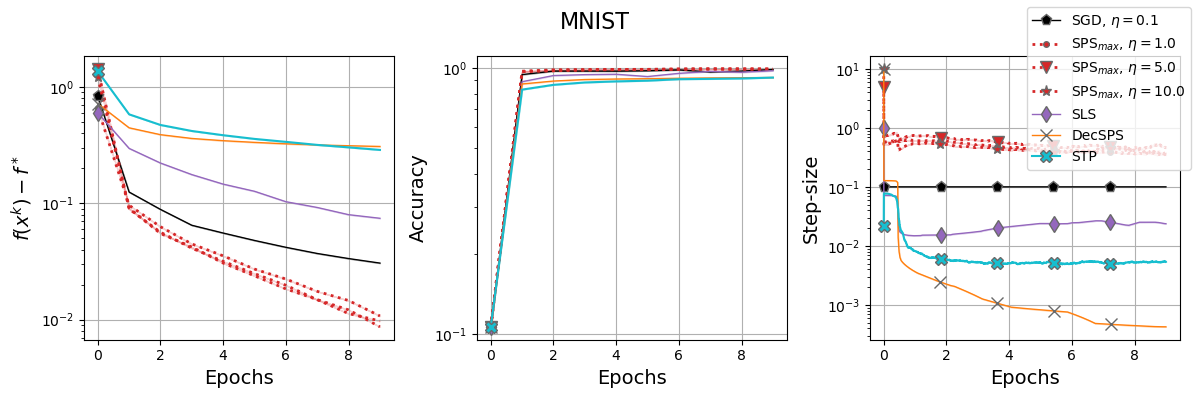

In [66]:
plotter(histories=histories, 
        colors=["black", "tab:red", "tab:red", "tab:red", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", ":", ":", ":", "-", "-", "-"],
        linewidths=[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.5],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8],
        f_star=np.asarray(0.0), 
        x_labels=["Epochs", "Epochs", "Epochs", "Epochs"],
        y_labels=[r"$f(x^k) - f^*$", "Accuracy", "Step-size", r"$\| \nabla f(x^k) \|^2$", "Test Accuracy", r"Step-size"],
        x_labels_fs=14, y_labels_fs=14,
        suptitle=f"MNIST",
        metrics=["train/loss", "test/accuracy/top1", "lr"],
        y_scales=["log", "log", "log", "log"],
        mov_ave=[True, True, True, True],
        # threshold=0.0,
        # acc_ylim=0.7,
        # filename=f"{dataset_name}_stochastic_logreg_4.pdf",
        )

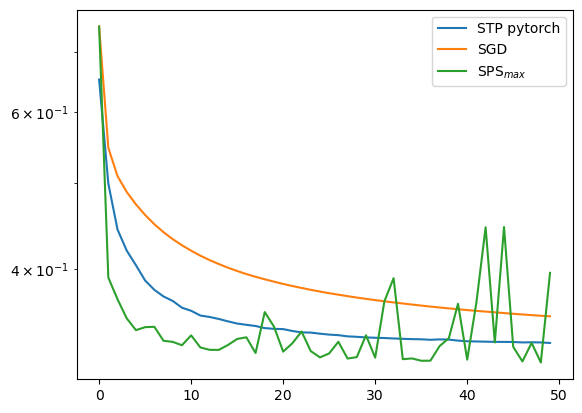

In [491]:
plt.semilogy(hist_stp["train/loss"], label="STP pytorch")
plt.semilogy(hist_sgd["train/loss"], label="SGD")
plt.semilogy(hist_sps["train/loss"], label=r"SPS$_{max}$")
plt.legend()

In [463]:
hist_np = utils.load_results(
    loss="logreg",
    setting="stochastic",
    dataset_name="a1a",
    batch_size=batch_size,
    n_epochs=200,
    optimizer="STP",
    lr="1_0",
    seed=0
)

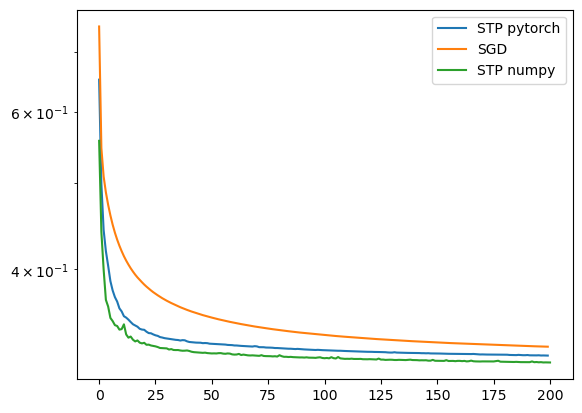

In [464]:
plt.semilogy(hist_stp["train/loss"], label="STP pytorch")
plt.semilogy(hist_sgd["train/loss"], label="SGD")
plt.semilogy(hist_np["train/loss"], label="STP numpy")
plt.legend()